In [1]:
import pandas as pd
main = pd.read_csv('../Raw_Data/Prostate_GSE46602.csv')
main.head()


,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,136,tumoral,8.767514,4.092134,6.006339,6.091951,2.738641,7.707960,6.702969,5.203349,...,13.852908,13.854510,14.953006,14.824910,3.710845,2.493435,2.913242,2.360155,2.758725,2.779035
1,137,tumoral,9.177852,5.688045,5.599253,5.943833,2.667376,6.737484,7.336429,6.246692,...,13.784316,13.776588,14.944678,14.798245,3.840439,2.452855,2.657462,2.480106,2.811486,3.098742
2,138,tumoral,8.415823,4.579540,5.562391,6.185697,2.747484,6.961582,6.809795,7.158062,...,13.833406,13.853554,14.929317,14.749283,3.960969,2.593110,2.839218,2.483863,2.939876,2.761388
3,139,tumoral,8.943121,6.577537,5.850425,5.846352,2.429107,6.492797,7.594337,6.060994,...,13.601130,13.604113,14.927910,14.753407,3.821295,2.629036,2.798198,2.487149,2.652175,2.600322
4,141,tumoral,8.658734,4.624722,6.882949,5.880421,2.517857,7.519646,6.840436,6.290670,...,13.961861,13.933318,14.994563,14.803339,3.990229,2.862215,2.766505,2.229823,2.630706,2.588111


In [2]:
lim_main = main[main.columns[:10]]
lim_main.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at
0,136,tumoral,8.767514,4.092134,6.006339,6.091951,2.738641,7.707960,6.702969,5.203349
1,137,tumoral,9.177852,5.688045,5.599253,5.943833,2.667376,6.737484,7.336429,6.246692
2,138,tumoral,8.415823,4.579540,5.562391,6.185697,2.747484,6.961582,6.809795,7.158062
3,139,tumoral,8.943121,6.577537,5.850425,5.846352,2.429107,6.492797,7.594337,6.060994
4,141,tumoral,8.658734,4.624722,6.882949,5.880421,2.517857,7.519646,6.840436,6.290670


In [30]:
%%writefile functions.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def DropSamples(df:pd.DataFrame):
    if 'samples' in df.columns:
        df = df.drop('samples', axis=1)
    return df


def calculate_difference(df:pd.DataFrame, tumor_column = 'type'):
    """
    Calculate the mean difference between two groups in a DataFrame based on the specified 'tumor_column'.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing data for comparison.
    - tumor_column (str, optional): The column defining the groups. Default is 'type'.

    Returns:
    - pd.DataFrame: A new DataFrame containing the means of each column for each group, 
                    as well as the differences between the means of the two groups.
    """    
    df2 = DropSamples(df).copy()

    means_df = df2.groupby(tumor_column).agg('mean').reset_index()

    # define Min_values Dict
    min_values = {}
    for col in means_df.columns[1:]:
        min_values[col] = means_df[col][0] - means_df[col][1]

    min_values_df = pd.DataFrame([min_values])
    min_values_df[tumor_column] = 'difference'

    # return new concatted dataframe
    return pd.concat([means_df, min_values_df], axis=0)


def plotSTDEV(df:pd.DataFrame, tumor_value = 'tumoral', tumor_column = 'type'):
    """
    Plot the standard deviation (STDEV) distribution of a specified 'tumor_value' within a DataFrame,
    grouped by the 'tumor_column'. The function generates a boxplot and a histogram for visualizing the distribution.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing data for visualization.
    - tumor_value (str, optional): The specific value within the 'tumor_column' for which the STDEV is plotted.
                                  Default is 'tumoral'.
    """
    df2 = DropSamples(df).copy()

    sted_df = df2.groupby(tumor_column).std().reset_index()
    sted_df_melt = sted_df[sted_df[tumor_column] == tumor_value].drop(tumor_column, axis=1).melt()

    f, ax  = plt.subplots(2,1,figsize=(10,5), sharex=True)
    ax[0] = sns.boxplot(sted_df_melt, ax=ax[0], orient='h')
    ax[1] = sns.histplot(sted_df_melt, ax=ax[1])

    plt.show()

    return sted_df_melt


# make function to plot the thing that we talked about

def getLowSTEDVList(df:pd.DataFrame, tumor_value = 'tumoral', tumor_column = 'type'):
    """
    Get a list of variables with a standard deviation (STDEV) less than 1 for a specific tumor group in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing data for analysis.
    - tumor_value (str, optional): The specific tumor group to analyze. Default is 'tumoral'.
    - tumor_column (str, optional): The column defining the tumor groups. Default is 'type'.

    Returns:
    - list: A list of variables with STDEV values less than 1 for the specified tumor group.
    """
    df2 = DropSamples(df).copy()

    sted_df = df2.groupby(tumor_column).std().reset_index()
    sted_df_melt = sted_df[sted_df[tumor_column] == tumor_value].drop(tumor_column, axis=1).melt()

    return sted_df_melt[sted_df_melt['value']<1]['variable'].to_list()


def getListDifferentialGenes(df:pd.DataFrame, psig=0.05, tumor_value = 'tumoral', tumor_column = 'type'):
    """
    Identify differentially expressed genes between a specified tumor group and the rest of the samples in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing gene expression data.
    - psig (float, optional): Significance threshold for identifying differentially expressed genes. Default is 0.05.
    - tumor_value (str, optional): The specific tumor group for which differential expression is assessed. Default is 'tumoral'.
    - tumor_column (str, optional): The column defining the tumor groups. Default is 'type'.

    Returns:
    - list: A list of gene names that are differentially expressed in the specified tumor group based on a t-test.
    """    
    df2 = df.copy()

    df_cancer = df2[df2[tumor_column]==tumor_value]
    df_normal = df2[df2[tumor_column]!=tumor_value]

    differential_expressed_genes = []
    for col in df_cancer.columns[2:]:
        t, pvalue= st.ttest_ind(df_cancer[col],df_normal[col], equal_var = False, alternative = 'two-sided')
        if pvalue < psig:
            differential_expressed_genes.append(str(col))

    return differential_expressed_genes


def find_correlated_genes(df:pd.DataFrame, threshold=0.95):
    """
    Identify and analyze genes with high correlation coefficients in a gene expression DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing gene expression data.
    - threshold (float, optional): The correlation coefficient threshold for identifying highly correlated genes. Default is 0.95.

    Returns:
    - Tuple: A tuple containing three elements:
        1. List: Information about correlated genes, including column names, correlation values, and index names.
        2. List: Names of genes to be excluded to avoid redundancy.
        3. pd.DataFrame: The correlation matrix of the input DataFrame.
    """
    df2 = DropSamples(df).copy()
    
    r_values = df2.corr()
    
    correlated_genes_list = []
    # Create a mask for values above the threshold
    mask = (r_values.to_numpy() > threshold) & (r_values.index.to_numpy() != r_values.columns.to_numpy()[:, None])

    # Extract the column and index names where the mask is True
    correlated_columns, correlated_rows = np.where(mask)

    for col, index in zip(r_values.columns[correlated_columns], r_values.index[correlated_rows]):
        value = r_values.at[index, col]
        correlated_genes_list.append([col, value, index])

    exclude_list = []
    included_columns = []

    for col in correlated_genes_list:
        if col[0] not in included_columns:
            exclude_list.append(col[0])
            included_columns.append(col[2])

    return correlated_genes_list, exclude_list, r_values

def find_correlated_genes_optimized(corr: pd.DataFrame, threshold=0.95):
    """
    Identify and analyze genes with high correlation coefficients in a gene expression DataFrame.
    Experimental function, "optimized" from the previous. This function loops over till no mutlicollinearity is found, but will take slightly longer.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing gene expression data.
    - threshold (float, optional): The correlation coefficient threshold for identifying highly correlated genes. Default is 0.95.

    Returns:
    - List: Names of genes to be excluded to avoid redundancy.
    """
    exclude_list = []
    corr2 = corr.copy()

    # Create mask over all columns
    while True:
        mask = (corr2.to_numpy() > threshold) & (corr2.index.to_numpy() != corr2.columns.to_numpy()[:, None])
        correlated_columns, correlated_rows = np.where(mask)
    
        correlated_genes_list = {}
        for col, index in zip(corr2.columns[correlated_columns], corr2.index[correlated_rows]):
            count = correlated_genes_list.get(col, 0)
            count += 1
            correlated_genes_list[col] = count

        count_df = pd.DataFrame(correlated_genes_list, index=[0]).melt().sort_values('value', ascending=False)
        highest_col_value = count_df['value'].iloc[0]

        if highest_col_value <= 1:
            break

        highest_count_genes = count_df[count_df['value'] == highest_col_value]['variable'].tolist()

        exclude_list.extend(highest_count_genes)
        corr2 = corr2.drop(highest_count_genes, axis=1)
        corr2 = corr2.drop(highest_count_genes)

        print(f"Loop completed, highest value was {highest_col_value} from genes {highest_count_genes}")

    return exclude_list

def trainLogisticModel(df: pd.DataFrame, ColumnToPredict='type', tumor_value = 'tumoral'):
    """
    Train a logistic regression model to predict a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing data for training and testing the model.
    - ColumnToPredict (str, optional): The column to be predicted using logistic regression. Default is 'type'.
    - tumor_value (str, optional): The specific tumor group to be treated as the positive label. Default is 'tumoral'.

    Returns:
    - Tuple: A tuple containing three elements:
        1. LogisticRegression: Trained logistic regression model.
        2. pd.DataFrame: Confusion matrix for model evaluation.
        3. dict: Dictionary containing various classification scores (e.g., accuracy, precision, recall).
    """
    df2 = DropSamples(df).copy()

    # Split into X/Y based on ColumnToPredict
    y = df2[ColumnToPredict]
    X = df2.drop([ColumnToPredict], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1337)

    # Peform underSampler if values are not equal
    if df2[ColumnToPredict].value_counts()[0] != df2[ColumnToPredict].value_counts()[1]:
        rus = RandomUnderSampler(random_state=69)
        X_train, y_train = rus.fit_resample(X_train, y_train)

    # Create LogisticRegression model
    classification = LogisticRegression(random_state=0, solver='lbfgs')
    classification.fit(X_train, y_train)

    # Create Prediction values
    y_pred = classification.predict(X=X_test)

    # return y_pred, y_test
    model, cm, scores = LogisticModelView(model=classification, y_pred=y_pred, y_test=y_test.values, pos_label=tumor_value)
    return model, cm, scores

def predict(model: LogisticRegression, X, tumor_value = 'tumoral'):
    """
    Do not use, not ready yet. Maybe will never be ready tbh might not really need this one :)
    """
    model, cm, scores = LogisticModelView(model=model, y_pred=model.predict(X=X), y_test=X, pos_label=tumor_value)
    return model, cm, scores

def LogisticModelView(model: LogisticRegression, y_pred, y_test, pos_label):
    """
    Evaluate and visualize the performance of a logistic regression model using a confusion matrix.

    Parameters:
    - model (LogisticRegression): Trained logistic regression model.
    - y_pred: Predicted values from the model.
    - y_test: True labels for evaluation.
    - pos_label (str): The positive label, typically the specific tumor group.

    Returns:
    - Tuple: A tuple containing three elements:
        1. LogisticRegression: Trained logistic regression model.
        2. pd.DataFrame: Confusion matrix for model evaluation.
        3. dict: Dictionary containing various classification scores (e.g., accuracy, precision, recall).
    """
    # Create Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    disp.plot()

    # Print Precision of CM
    scores = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_true=y_test, y_pred=y_pred, pos_label=pos_label),
        'recall': recall_score(y_test, y_pred, pos_label=pos_label),
        'f1': f1_score(y_test, y_pred, pos_label=pos_label),
        'kappa': cohen_kappa_score(y_test, y_pred)
    }

    return model, cm, scores



def quantileTransformer(df:pd.DataFrame, qt = None):
    """
    Apply quantile transformation to a DataFrame, transforming numerical columns to follow a normal distribution.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing numerical data for transformation.
    - qt (QuantileTransformer or None, optional): An existing QuantileTransformer object to apply, or None to fit a new one. Default is None.

    Returns:
    - Tuple: A tuple containing two elements:
        1. pd.DataFrame: Transformed DataFrame with numerical columns following a normal distribution.
        2. QuantileTransformer: The fitted or provided QuantileTransformer object.
    """
    df_transformed = df.copy()

    if qt is None:
        # Fit new dataset, if none is given
        qt = QuantileTransformer (output_distribution ='normal')
        qt.fit(df_transformed[df_transformed.columns[2:]])
    
    # Apply Transformation to data set
    df_transformed[df_transformed.columns[2:]] = qt.transform(df_transformed[df_transformed.columns[2:]])
    return df_transformed, qt
    

Overwriting functions.py


<Axes: >

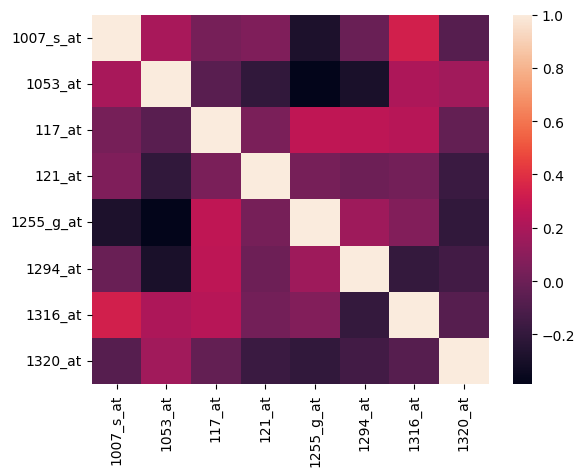

In [34]:
import seaborn as sns
sns.heatmap(lim_main.drop(['samples', 'type'], axis=1).corr())

In [6]:
lst = getListDifferentialGenes(main)

In [7]:
new_main = main[[
    'samples', 'type'
] + lst]

In [8]:
corr = new_main.drop(['samples', 'type'], axis=1).corr()

In [26]:
b = find_correlated_genes_optimized(corr, 0.95)
b

Loop completed, highest value was 9 from genes ['AFFX-BioC-5_at', 'AFFX-BioB-3_at', 'AFFX-r2-Ec-bioC-3_at', 'AFFX-r2-Ec-bioB-M_at', 'AFFX-BioB-M_at', 'AFFX-BioC-3_at']
Loop completed, highest value was 7 from genes ['211456_x_at']
Loop completed, highest value was 6 from genes ['207730_x_at']
Loop completed, highest value was 5 from genes ['211417_x_at', '211983_x_at', '204745_x_at', '206461_x_at', '207131_x_at', '208284_x_at', '224585_x_at', '211416_x_at', '212988_x_at']
Loop completed, highest value was 4 from genes ['211765_x_at', '211978_x_at', '209863_s_at', '212661_x_at', '201293_x_at', '211378_x_at']
Loop completed, highest value was 3 from genes ['208929_x_at', '217398_x_at', '213453_x_at', '209813_x_at', '241926_s_at', '1563392_at', '210427_x_at', '212734_x_at', '212581_x_at', '204538_x_at', '210679_x_at', '229447_x_at', '211025_x_at', '213541_s_at', '215806_x_at', '211144_x_at', '212191_x_at', '211527_x_at', '203242_s_at', '216920_s_at', '201590_x_at', '211940_x_at', '202343_

['AFFX-BioC-5_at',
 'AFFX-BioB-3_at',
 'AFFX-r2-Ec-bioC-3_at',
 'AFFX-r2-Ec-bioB-M_at',
 'AFFX-BioB-M_at',
 'AFFX-BioC-3_at',
 '211456_x_at',
 '207730_x_at',
 '211417_x_at',
 '211983_x_at',
 '204745_x_at',
 '206461_x_at',
 '207131_x_at',
 '208284_x_at',
 '224585_x_at',
 '211416_x_at',
 '212988_x_at',
 '211765_x_at',
 '211978_x_at',
 '209863_s_at',
 '212661_x_at',
 '201293_x_at',
 '211378_x_at',
 '208929_x_at',
 '217398_x_at',
 '213453_x_at',
 '209813_x_at',
 '241926_s_at',
 '1563392_at',
 '210427_x_at',
 '212734_x_at',
 '212581_x_at',
 '204538_x_at',
 '210679_x_at',
 '229447_x_at',
 '211025_x_at',
 '213541_s_at',
 '215806_x_at',
 '211144_x_at',
 '212191_x_at',
 '211527_x_at',
 '203242_s_at',
 '216920_s_at',
 '201590_x_at',
 '211940_x_at',
 '202343_x_at',
 '211626_x_at',
 '213503_x_at',
 '214870_x_at',
 '208755_x_at',
 '213735_s_at',
 '213736_at',
 '214351_x_at',
 '208816_x_at',
 '213826_s_at',
 '213828_x_at',
 '208527_x_at',
 'AFFX-r2-Ec-bioD-5_at',
 '209366_x_at',
 '201154_x_at',
 '20

In [27]:
print(len(b))

119


In [ ]:
b.head()

In [43]:
corr.head()

,1294_at,1316_at,1431_at,1438_at,1487_at,1552256_a_at,1552257_a_at,1552258_at,1552263_at,1552264_a_at,...,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-TrpnX-M_at
1294_at,1.000000,-0.196297,0.265514,-0.158850,-0.390742,-0.322735,-0.629106,0.619377,-0.118182,-0.243256,...,0.639111,0.641003,0.665970,0.673197,0.687415,0.506664,0.513898,0.140528,0.148749,0.037070
1316_at,-0.196297,1.000000,-0.107147,0.297960,0.401575,0.437606,0.492194,-0.238358,0.287821,0.222830,...,-0.044619,-0.012882,-0.056788,-0.128206,-0.148492,-0.342041,-0.267291,-0.502214,-0.525167,0.257226
1431_at,0.265514,-0.107147,1.000000,-0.026961,-0.093128,-0.239341,-0.246241,0.172745,-0.272039,-0.196795,...,0.344679,0.318784,0.317479,0.332442,0.277273,0.143749,0.138784,-0.163597,-0.168589,0.065501
1438_at,-0.158850,0.297960,-0.026961,1.000000,0.444146,0.296720,0.441981,-0.112081,0.111677,-0.172533,...,-0.219205,-0.196298,-0.257506,-0.360003,-0.399195,-0.477992,-0.463958,-0.283587,-0.551300,0.612591
1487_at,-0.390742,0.401575,-0.093128,0.444146,1.000000,0.395359,0.616744,-0.144776,0.321502,0.183275,...,-0.335935,-0.332841,-0.372503,-0.476981,-0.495966,-0.568344,-0.477054,-0.389978,-0.528519,0.256257


In [39]:
test = corr.copy()

In [41]:
test.head()

,1294_at,1316_at,1431_at,1438_at,1487_at,1552256_a_at,1552257_a_at,1552258_at,1552263_at,1552264_a_at,...,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-TrpnX-M_at
1294_at,1.000000,-0.196297,0.265514,-0.158850,-0.390742,-0.322735,-0.629106,0.619377,-0.118182,-0.243256,...,0.639111,0.641003,0.665970,0.673197,0.687415,0.506664,0.513898,0.140528,0.148749,0.037070
1316_at,-0.196297,1.000000,-0.107147,0.297960,0.401575,0.437606,0.492194,-0.238358,0.287821,0.222830,...,-0.044619,-0.012882,-0.056788,-0.128206,-0.148492,-0.342041,-0.267291,-0.502214,-0.525167,0.257226
1431_at,0.265514,-0.107147,1.000000,-0.026961,-0.093128,-0.239341,-0.246241,0.172745,-0.272039,-0.196795,...,0.344679,0.318784,0.317479,0.332442,0.277273,0.143749,0.138784,-0.163597,-0.168589,0.065501
1438_at,-0.158850,0.297960,-0.026961,1.000000,0.444146,0.296720,0.441981,-0.112081,0.111677,-0.172533,...,-0.219205,-0.196298,-0.257506,-0.360003,-0.399195,-0.477992,-0.463958,-0.283587,-0.551300,0.612591
1487_at,-0.390742,0.401575,-0.093128,0.444146,1.000000,0.395359,0.616744,-0.144776,0.321502,0.183275,...,-0.335935,-0.332841,-0.372503,-0.476981,-0.495966,-0.568344,-0.477054,-0.389978,-0.528519,0.256257


In [42]:
test.drop('1294_at')

,1294_at,1316_at,1431_at,1438_at,1487_at,1552256_a_at,1552257_a_at,1552258_at,1552263_at,1552264_a_at,...,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-TrpnX-M_at
1316_at,-0.196297,1.000000,-0.107147,0.297960,0.401575,0.437606,0.492194,-0.238358,0.287821,0.222830,...,-0.044619,-0.012882,-0.056788,-0.128206,-0.148492,-0.342041,-0.267291,-0.502214,-0.525167,0.257226
1431_at,0.265514,-0.107147,1.000000,-0.026961,-0.093128,-0.239341,-0.246241,0.172745,-0.272039,-0.196795,...,0.344679,0.318784,0.317479,0.332442,0.277273,0.143749,0.138784,-0.163597,-0.168589,0.065501
1438_at,-0.158850,0.297960,-0.026961,1.000000,0.444146,0.296720,0.441981,-0.112081,0.111677,-0.172533,...,-0.219205,-0.196298,-0.257506,-0.360003,-0.399195,-0.477992,-0.463958,-0.283587,-0.551300,0.612591
1487_at,-0.390742,0.401575,-0.093128,0.444146,1.000000,0.395359,0.616744,-0.144776,0.321502,0.183275,...,-0.335935,-0.332841,-0.372503,-0.476981,-0.495966,-0.568344,-0.477054,-0.389978,-0.528519,0.256257
1552256_a_at,-0.322735,0.437606,-0.239341,0.296720,0.395359,1.000000,0.578383,-0.170316,0.220145,0.501943,...,-0.275150,-0.208974,-0.255458,-0.359736,-0.365745,-0.434607,-0.359832,-0.262267,-0.424885,0.385145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AFFX-r2-Ec-bioD-3_at,0.506664,-0.342041,0.143749,-0.477992,-0.568344,-0.434607,-0.658133,0.429023,-0.184792,-0.123851,...,0.656057,0.632837,0.678121,0.757525,0.765996,1.000000,0.973461,0.588087,0.728331,-0.456953
AFFX-r2-Ec-bioD-5_at,0.513898,-0.267291,0.138784,-0.463958,-0.477054,-0.359832,-0.594893,0.442233,-0.120095,-0.115855,...,0.669071,0.642518,0.684320,0.754380,0.762137,0.973461,1.000000,0.531057,0.690192,-0.451794
AFFX-r2-P1-cre-3_at,0.140528,-0.502214,-0.163597,-0.283587,-0.389978,-0.262267,-0.431953,0.192936,0.024424,-0.070731,...,0.043830,0.053573,0.079236,0.160550,0.194999,0.588087,0.531057,1.000000,0.757402,-0.308466
AFFX-r2-P1-cre-5_at,0.148749,-0.525167,-0.168589,-0.551300,-0.528519,-0.424885,-0.565857,0.172512,-0.074769,-0.159806,...,0.187002,0.162793,0.219069,0.326735,0.355099,0.728331,0.690192,0.757402,1.000000,-0.507809
